# CS229 Problem Set Instructions


## Setup for Written Parts

1. We have provided a LaTeX template in the `tex/` directory to make it easy to typeset your homework solutions.
2. Every problem has its own directory (*e.g.,* `tex/featuremaps/` for Problem 1).
3. Every subproblem has two files within the parent problem’s directory:
  - The problem statement, *e.g.* `tex/featuremaps/01-degree-3-math.tex` for Problem 1(a)). You do not need to modify this.
  - Your solution, *e.g.* `tex/featuremaps/01-degree-3-math-sol.tex` for your solution to Problem 1(a). You will need to modify these files (and the source files in `src` for coding parts).
4. You can use the given `Makefile` to typeset your solution, or use an editor with built-in typesetting such as TeXShop (comes free with the standard [LaTeX distribution](https://www.latex-project.org/get/)) or [Texpad](https://www.texpad.com/) (separate download, not free).


## Setup for Coding Parts

1. Install [Miniconda](https://docs.conda.io/en/latest/miniconda.html)
  - Conda is a package manager that sandboxes your project’s dependencies in a virtual environment
  - Miniconda contains Conda and its dependencies with no extra packages by default (as opposed to Anaconda, which installs some extra packages)
2. Extract the zip file and run `conda env create -f environment.yml` from inside the extracted directory.
  - This creates a Conda environment called `cs229`
3. Run `source activate cs229`
  - This activates the `cs229` environment
  - Do this each time you want to write/test your code
4. (Optional) If you use PyCharm:
  - Open the `src` directory in PyCharm
  - Go to `PyCharm` > `Preferences` > `Project` > `Project interpreter`
  - Click the gear in the top-right corner, then `Add`
  - Select `Conda environment` > `Existing environment` > Button on the right with `…`
  - Select `/Users/YOUR_USERNAME/miniconda3/envs/cs229/bin/python`
  - Select `OK` then `Apply`
5. Notice some coding problems come with `util.py` file. In it you have access to methods that do the following tasks:
  - Load a dataset in the CSV format provided in the problem
  - Add an intercept to a dataset (*i.e.,* add a new column of 1s to the design matrix)
  - Plot a dataset and a linear decision boundary. Some plots might require modified plotting code, but you can use this as a starting point.
7. Notice that start codes are provided in each problem directory (e.g. `gda.py`, `posonly.py`)
  - Within each starter file, there are highlighted regions of the code with the comments ** START CODE HERE ** and ** END CODE HERE **. You are strongly suggested to make your changes only within this region. You can add helper functions within this region as well.
8. Once you are done with all the code changes, run `make_zip.py` to create a `submission.zip`.
  - You must upload this `submission.zip` to Gradescope.


# Logistic Regression with Newtons Method

In [1]:
import numpy as np
import util
from functools import partial

### Model

In [2]:
def sigmoid(z):
    return 1/(1 + np.power(np.e,-z))

class LogisticRegression:
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """
    def __init__(self, step_size=0.01, max_iter=1000000, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta_0 = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.theta = theta_0
    
    def h_x(self, theta, x):
        return sigmoid(x@theta)
    
    def gradient_empirical_loss(self, theta, x, y):
        # gradient of the negative averaged log likelihood
        h_x = self.h_x(theta, x)
        return -1*np.mean((y - h_x)*x, axis=0)
    
    def hessian_empirical_loss(self, theta, x, y):
        m = len(theta)
        h_x = self.h_x(theta, x)
        hessian = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                hessian[i, j] = np.mean(h_x*(1-h_x)*x[:,i:i+1]*x[:,j:j+1], axis=0)
        
        return hessian
                
    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (n_examples, dim).
            y: Training example labels. Shape (n_examples,).
        """
        # *** START CODE HERE ***
        y = y.reshape((-1,1))
        m = x.shape[1]
        if self.theta_0 is None:
            self.theta = np.zeros((x.shape[1], 1))
            
        grad_J_theta = partial(self.gradient_empirical_loss, x=x, y=y)
        
        hessian_J_theta = partial(self.hessian_empirical_loss, x=x, y=y)
        
        prev_theta = self.theta + 2*self.eps 
        thetas = [self.theta]
        for step in range(self.max_iter):
            if np.sum(np.abs(self.theta-prev_theta)) <= self.eps:
                break
            prev_theta = self.theta
            quotient = (np.linalg.inv(hessian_J_theta(self.theta)) @ grad_J_theta(self.theta)).reshape((m, 1))
            self.theta = self.theta - self.step_size*quotient 
            thetas.append(self.theta)
        return thetas
        # *** END CODE HERE ***

    def predict(self, x):
        """Return predicted probabilities given new inputs x.

        Args:
            x: Inputs of shape (n_examples, dim).

        Returns:
            Outputs of shape (n_examples,).
        """
        # *** START CODE HERE ***
        return self.h_x(self.theta, x)
        # *** END CODE HERE ***

# if __name__ == '__main__':
#     main(train_path='ds1_train.csv',
#          valid_path='ds1_valid.csv',
#          save_path='logreg_pred_1.txt')

#     main(train_path='ds2_train.csv',
#          valid_path='ds2_valid.csv',
#          save_path='logreg_pred_2.txt')


In [3]:
def main(train_path, valid_path, save_path):
    """Problem: Logistic regression with Newton's Method.

    Args:
        train_path: Path to CSV file containing dataset for training.
        valid_path: Path to CSV file containing dataset for validation.
        save_path: Path to save predicted probabilities using np.savetxt().
    """
    x_train, y_train = util.load_dataset(train_path, add_intercept=True)
    x_valid, y_valid = util.load_dataset(valid_path, add_intercept=True)

    m = x_train.shape[1]
    
    # *** START CODE HERE ***
    # Train a logistic regression classifier
    lr = LogisticRegression()
    thetas = lr.fit(x_train, y_train)
    # Plot decision boundary on top of validation set set
    util.plot(x_valid, y_valid.reshape(-1), thetas[-1], save_path=None)
    # Use np.savetxt to save predictions on eval set to save_path
    # *** END CODE HERE ***


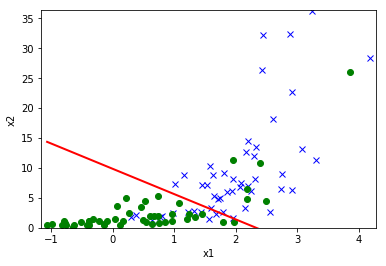

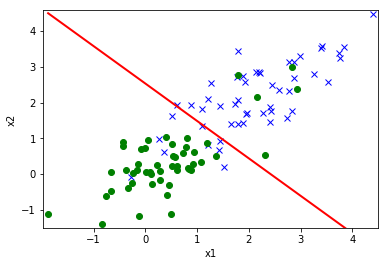

In [4]:
main(train_path='ds1_train.csv',
         valid_path='ds1_valid.csv',
         save_path='logreg_pred_1.txt')

main(train_path='ds2_train.csv',
     valid_path='ds2_valid.csv',
     save_path='logreg_pred_2.txt')

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
train_path = 'ds1_train.csv'
x_train, y_train = util.load_dataset(train_path, add_intercept=True)

In [7]:
x_train_0 = x_train[y_train == 0]

(array([ 2.,  5., 21., 47., 64., 75., 94., 61., 20., 11.]),
 array([-2.60676589, -2.06600854, -1.52525119, -0.98449385, -0.4437365 ,
         0.09702085,  0.63777819,  1.17853554,  1.71929289,  2.26005023,
         2.80080758]),
 <a list of 10 Patch objects>)

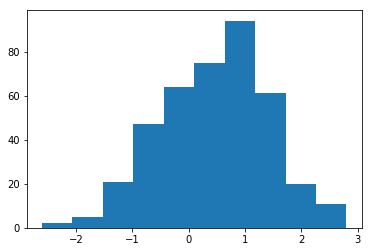

In [8]:
plt.hist(np.log(x_train_0[:,2]))

In [9]:
import scipy as scp
from scipy import stats